In [109]:
# Exploring the use of multiprocessing to speed up find_SARFI.py script

### Setup

In [110]:
# Import packages
import numpy as np
import pandas as pd
import pickle
import os
os.environ["H5PY_DEFAULT_READONLY"] = "1" # Surpress h5py deprecation warnings
import socket
import argparse
from datetime import datetime
from seticore import viewer
import multiprocessing
import matplotlib.pyplot as plt

### Simple Example 

In [111]:
# Do a simple example to understand what I'm doing

def square(n): 
	return [(n*n)] * 3 

# input list 
mylist = [1,2,3,4,5] 

# creating a pool object 
p = multiprocessing.Pool() 

# map list to target function 
result = p.map(square, mylist) 

print(result) 


[[1, 1, 1], [4, 4, 4], [9, 9, 9], [16, 16, 16], [25, 25, 25]]


### Build index of stamp uri and index to go along with every hit in the df

##### Function which, when given information from a row of the hits database, will find the stamp uri and index in the uri of that row

In [112]:
# Look for the stamp in a single stamp file
# Assumes the stamp_uri exists 
def find_stamp_in_single_file(stamp_uri, hit_frequency, threshold):
    # Check each stamp in the file to see if it matches
    stamps_gen = viewer.read_stamps(stamp_uri, find_recipe=True)
    for i, stamp in enumerate(stamps_gen):
        assert(stamp != None)
        assert(stamp.recipe != None)
        if abs(stamp.stamp.signal.frequency - hit_frequency) < threshold*1e-6:
            # Found the stamp!
            return i, stamp
    
    # Didn't find the stamp in this whole file of stamps
    return None, None

# Given a stamp_uri, increments the index of the stamp file by one (so if it's /.../...seticore.0000.stamps it goes to /.../...seticore.0001.stamps)
def increment_stamp_uri(stamp_uri):
    split_uri = stamp_uri.split('.')
    assert(split_uri[-1] == 'stamps')
    num = int(split_uri[-2])
    num += 1
    split_uri[-2] = str(num).zfill(4)
    return ".".join(split_uri)

# Finds where the stamp of a given hit is
# Takes:
# - stamp URI (of stamp file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location_helper(stamp_uri, hit_frequency, threshold):
    # Check stamp file passed in exists
    if not os.path.exists(stamp_uri):
        return None, None
    
    # Look for stamp in the stamp file given
    index, stamp = find_stamp_in_single_file(stamp_uri, hit_frequency, threshold)
    if (index != None) and (stamp != None):
        return stamp_uri, index
    else:
        # Check if there's another stamp file (because stamps can get split up into multiple files)
        return find_stamp_location_helper(increment_stamp_uri(stamp_uri), hit_frequency, threshold)

# Finds where the stamp of a given hit is
# Takes:
# - hit URI (of .hits file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location(hit_uri, hit_frequency, threshold=500):
    # Convert a filepath from pointing to a .hits
    # to a .stamps file for the same uri
    # If given a .stamps ending, doesn't change it
    def stamp_filepath_of(hits_filepath):
        return hits_filepath.replace('.hits', '.0000.stamps')

    return find_stamp_location_helper(stamp_filepath_of(hit_uri), hit_frequency, threshold)

#### Small dataset examples

In [113]:
# Load in simple small dataset for testing
data_dir = "/mnt/cosmic-gpu-1/data0/nstiegle/representative_samples/"
filename = "hits_in_first_stamp.csv"
data_filename = data_dir + filename
df = pd.read_csv(data_filename)
print(df.shape)

(85, 29)


In [114]:
# Check with a single row to see if it works
stamp_uri, stamp_index = find_stamp_location(df.file_uri[0], df.signal_frequency[0])
print(stamp_uri)
print(stamp_index)

/mnt/cosmic-storage-2/data1/vla_target/23A-362.sb43789194.eb44583327.60212.544836180554/23A-362.sb43789194.eb44583327.60212.544836180554.9.1/23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.raw.seticore.0000.stamps
28


In [101]:
%%timeit
# Check with a single row to see if it works
stamp_uri, stamp_index = find_stamp_location(df.file_uri[0], df.signal_frequency[0])
# print(stamp_uri)
# print(stamp_index)

2.63 s ± 1.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
# Try with a simple for loop to get all the info from this small dataset
uris = []
indices = []
for index, row in df.iterrows():
    stamp_uri, stamp_index = find_stamp_location(row.file_uri, row.signal_frequency)
    uris.append(stamp_uri)
    indices.append(stamp_index)

uris = np.array(uris)
indices = np.array(indices)

KeyboardInterrupt: 

In [34]:
# Check things are working
assert(len(np.unique(uris)) == 1)
assert(len(np.unique(indices) == len(indices)))

In [32]:
%%timeit
uris = []
indices = []
for index, row in df.iterrows():
    stamp_uri, stamp_index = find_stamp_location(row.file_uri, row.signal_frequency)
    uris.append(stamp_uri)
    indices.append(stamp_index)

uris = np.array(uris)
indices = np.array(indices)

/home/nstiegle/miniforge3/envs/stamp_viewer/lib/python3.7/site-packages/seticore/viewer.py:125: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.h5 = h5py.File(filepath)


1.34 s ± 75.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
# So it takes 1.34 seconds for 85 rows
t_per_row_s = 1.34 / 85
t_for_1in25_s = t_per_row_s * 1248312
t_for_all = t_for_1in25_s * 25
print(f"So it'll take {round(t_for_1in25_s / 60 / 60, 3)}h for 1 in 25")
print(f"So it'll take {round(t_for_all / 60 / 60, 3)}h for all data")

So it'll take 5.466h for 1 in 25
So it'll take 136.662h for all data


In [69]:
# Does multiprocessing work with these functions?

# input list 
inputs = [(row.file_uri, row.signal_frequency) for index, row in df.iterrows()] 

# creating a pool object 
p = multiprocessing.Pool() 

# map list to target function 
result = np.array(p.starmap(find_stamp_location, inputs))
result_uris = result[:, 0]
result_indices = result[:, 1].astype(int)
assert(np.array_equal(result_uris, uris))
assert(np.array_equal(result_indices, indices))

In [ ]:
%%timeit
# Benchmark it
# Create input array
inputs = [(row.file_uri, row.signal_frequency) for index, row in df.iterrows()] 

# creating a pool object 
p = multiprocessing.Pool() 

# map list to target function 
result = np.array(p.starmap(find_stamp_location, inputs))
result_uris = result[:, 0]
result_indices = result[:, 1].astype(int)

In [94]:
%%timeit

# What if I just do it single core?
inputs = [(row.file_uri, row.signal_frequency) for index, row in df.iterrows()] 
result = np.array([find_stamp_location(uri, f) for uri, f in inputs])
result_uris = result[:, 0]
result_indices = result[:, 1].astype(int)

2min 46s ± 39.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
# input list 
start_time = datetime.now()
inputs = [(row.file_uri, row.signal_frequency) for index, row in df.iterrows()] 
after_inputs = datetime.now()
print("Took:", after_inputs - start_time, "to create inputs array")

# creating a pool object 
p = multiprocessing.Pool() 

# map list to target function 
result = np.array(p.starmap(find_stamp_location, inputs))
result_uris = result[:, 0]
result_indices = result[:, 1].astype(int)
end = datetime.now()
print("Took:", end - after_inputs, "to run on all data")

Took: 0:00:00.009801 to create inputs array


Took: 0:00:02.598647 to run arrays


#### Big dataset?

In [45]:
# Let's see if we can make the whole dataset faster
# Load in larger dataset
data_dir = "/mnt/cosmic-gpu-1/data0/nstiegle/representative_samples/"
filename = "1in25_targets.csv"
data_filename = data_dir + filename
big_df = pd.read_csv(data_filename)
print(big_df.shape)

(1248312, 30)


In [75]:
# input list 
start_time = datetime.now()
inputs = [(row.file_uri, row.signal_frequency) for index, row in big_df[:1000].iterrows()] 
after_inputs = datetime.now()
print("Took:", after_inputs - start_time, "to create inputs array")

# creating a pool object 
p = multiprocessing.Pool() 

# map list to target function 
result = np.array(p.starmap(find_stamp_location, inputs))
big_result_uris = result[:, 0]
big_result_indices = result[:, 1].astype(int)
end = datetime.now()
print("Took:", end - after_inputs, "to run arrays")


Took: 0:00:00.094765 to create inputs array


KeyboardInterrupt: 

#### Group by file so each process takes one file 

Should really be doing this with the full dataset of 32M hits

In [105]:
file_groups = big_df.groupby("file_uri")
print(len(file_groups))

120860


Text(0.5, 0, 'Number of Stamps poining to each .hits file ')

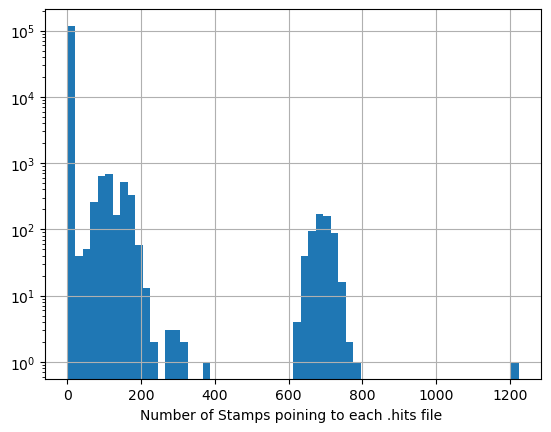

In [108]:
(file_groups.size()).hist(bins=60)
plt.yscale('log')
plt.xlabel("Number of Stamps poining to each .hits file ")


In [ ]:
# group_list = list(file_groups)
# idx = np.where(file_groups.size() > 25000)[0][0]
# uri, group = group_list[idx]